# Previously

We practiced the workflow of defining/building neural nets and training them which involved defining the loss and optimizer and doing the backpropagation. We also learned how to get the test and train losses and try it out on one image. Our results are kind of good; however, we also need to quantify the "good" in our performance. Also, that's not the end, the results can be better! 

# In this notebook,

We will learn about:
- the concepts regarding one of the main subprocceses of our workflow-- the Validation Pass
- improving our neural network
  - we will learn how to solve overfitting via regularization such as dropout
  - we will look at the use of the validation set
- to complete the whole basic process, we'll learn about Inference


# Conceptual

We introduce some new terms here:

**1. Inference**
- this is done after the training the network
- a term borrowed from statistics which actually means making predictions

**2. Overfitting**
- the problem in which neural networks have a tendency to perform too well on the training data and aren't able to generalize to data that hasn't been seen before.
- this impairs the inference performance

**3. Validation Set**
- data used to test for overfitting while training
- these are the data not in the training set


**Overall**

These terms makes sense by:
- We do inferences; however, overfitting lurks. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training.

# Coding in PyTorch

## Preliminaries

Here we do:
- Downloading and Loading of Data along with the creation of datasets
- Defining/Building Neural Networks

### 1. Dowloading and Loading the Dataset

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:04, 5886700.81it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 38145.07it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:02, 1680266.19it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


8192it [00:00, 15054.20it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


***Remark: the Test Set***
- As we can see, the **test set*** was created by setting `train = False` above
- The test set contains images just like the training set
- Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

### 2. Build the Neural Network

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Adding Validation Pass

This is tied to performance metrics. Reiterating:

**validation set**
- the goal is to measure the model's performance on data that isn't part of the training set

**Performance Metrics**
- standards used to tell how the model is performing
- examples are accuracy, [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)), and top-5 error rate.


***Remark:***
- Here we focus on accuracy

### 1. One batch and one forward pass
- we do only a forward pass with one batch from the test set

#### a. Set Up the Model

In [0]:
# Setting Up the model and images and label

model = Classifier()

images, labels = next(iter(testloader))
# with this we have the true values

#### b. Calculate Accuracy

**accuracy**
- (number of correct predictions divided by total number of values considered) * 100%

Thus to get accuracy, we want to compare the true labels containing the correct classes with the predicted classes. 

The steps are as follows:


In [4]:
# 1. Get the class probabilities
ps = torch.exp(model(images))
# recall: our model returns a log-softmax output
# but this time we want the class probabilities
# so we call torch.exp to turn it back to that

# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


Since for every image, we have probabilities for each class. 
We only want the class with highest probability to be the predicted label. 

Rephrasing that one will be:

**predicted label**
- the class that has the highest prediction among the other classes 

So we do:

In [5]:
# 2. Get the predicted label
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

tensor([[3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3]])


**ps.topk method**
- returns the *k* highest values

**ps.topk(1)**
- returns the most likely class
- returns a tuple of the top-k values and the top-k indices
  - that is, if the highest value is the fifth element, we'll get 4 as the index

  


In [0]:
# 3. Know which predictions are correctly labeled. 
# that is, 0 for wrong - 1 for right

equals = top_class == labels.view(*top_class.shape)
# recall: .view is used to change the shape of the tensor
# this is because top_class is a 2D tensor (64,1) and
# labels is 1D with shape (64)

In [7]:
# 4. Calculate the percentage of predictions

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


(copying again here)

**accuracy**
- (number of correct predictions divided by total number of values considered) * 100%

in our case, since we use 1 for correct, 
number of correct predictions = sum of 1s in `equals`
total number of values considered is = length of equals

However, we converted `equals` to a float tensor since `torch.mean` do not accept byte tensors which is initally the type of our `equal`.



***Remark:***
- Such a low accuracy? That's because our network is untrained. 

Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. 

### 2. Entire Dataset - Training the network with Validation pass (30 epochs)

#### The Process

**Bit of Change: Turning off the Gradients**

 Since we're not updating our parameters in the validation pass, we can speed up the by turning off gradients using torch.no_grad():
 ```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

Here's how we do training the network with Validation Pass:


In [0]:
# 1. Define all preliminary variables

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []

In [9]:
# 2 Train the Network with Validation Pass

for e in range(epochs):
    running_loss = 0

    # 2a. We do out usual flow
    #     - optimizer
    #     - loss
    #     - backprop
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    # now that we've already trained through the entire dataset
    # let's test the adjustments made (the weights, etc)

    #2b Validation pass 
    # actually the same as above but
    # - we're using the test dataset as the validation dataset
    # - we're computing the accuracy per epoch     
    else:
        test_loss = 0
        accuracy = 0
      
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                # this is what we did above in the One Pass
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.513..  Test Loss: 0.473..  Test Accuracy: 0.832
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.440..  Test Accuracy: 0.840
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.393..  Test Accuracy: 0.858
Epoch: 4/30..  Training Loss: 0.331..  Test Loss: 0.371..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.378..  Test Accuracy: 0.867
Epoch: 6/30..  Training Loss: 0.305..  Test Loss: 0.377..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.374..  Test Accuracy: 0.871
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.367..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.270..  Test Loss: 0.382..  Test Accuracy: 0.869
Epoch: 10/30..  Training Loss: 0.262..  Test Loss: 0.357..  Test Accuracy: 0.880
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.405..  Test Accuracy: 0.861
Epoch: 12/30..  Training Loss: 0.249..  Test Loss: 0.425..  Test Accuracy: 0.862
Epoch: 13/30..  Training Loss: 0.245.

***Remark:***
- Do not be confused here. We named the validation loss as the test loss. Later on, we'll use the three of them. 

**Spoiler: Difference of validation dataset and test dataset**

*you actually know this but restating here

**Validation Dataset**
- "test dataset" (in a sense as it is used to get the accuracy) used while training 

**Test Dataset**
- used after training
- most likely used in saved models (As we will learn later)

#### Visualizing

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

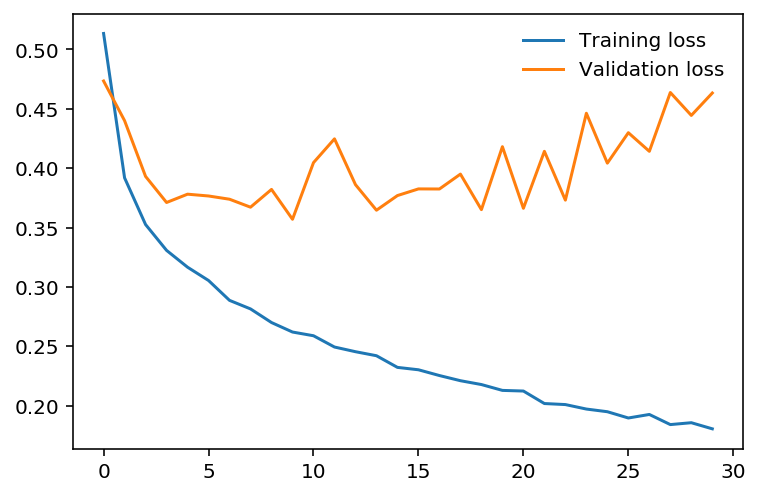

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

We're having a problem of overfitting here

## Improving Performance

### Conceptual (with little bit of code)

#### The Problem of Overfitting

![Overfitting](https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/overfitting.png?raw=true)

**Overfitting**
- Decreasing Train loss: when the network learns the training set better and better, resulting in training losses
- Increasing Validation loss: means that the network starts having problems generalizing data outside the training set


#### Strategies for Reducing Overfitting




##### **1. Early-stopping**
- to use the model with the lowest validation loss
  - you heard that right. To make sense, in practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.
- *In this example that can be found around 8-10 training epochs



##### **2. Dropout**
- this is done outside early-stopping
  - means that you can use both of them at the same time
- the randomly dropping of input units
- this forces the network to share information between weights, increasing it's ability to generalize to new data

###### Sample Code


```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```


###### Guidelines in using Dropout
There are parts where we want to turn on and off the Dropout.

**During Training**
- We want **to use** dropout to prevent overfitting
- we use `model.train()`

**During Validation, Testing and whenever we Make Predictions**
- We want to not use dropout since we want to use the entire network
- we use `model.eval()`

In general, the whole process of the validation loop with Dropout is like:
1. Turn OFF the gradient 
2. Set the model to evaluation mode to not use Dropout
3. Calculate the Validation loss and metric
4. Set the model back to train mode to use Dropout

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

### Coding All Previous Processes with Dropout Solution

So far our process is: (after Loading the Data and Splitting the dataset)
1. Define/Build the Network with Dropout
2. Training
  - includes loss, optimizers, and backprop + Dropout
3. Validation Pass 
  - includes calculation of accuracy + No Dropout

In [0]:
# 1. Define/Build the Network with Dropout

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [13]:
# 2. Training + Dropout
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # 3. Validation pass + No Dropout
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.609..  Test Loss: 0.493..  Test Accuracy: 0.821
Epoch: 2/30..  Training Loss: 0.490..  Test Loss: 0.440..  Test Accuracy: 0.846
Epoch: 3/30..  Training Loss: 0.452..  Test Loss: 0.417..  Test Accuracy: 0.847
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.415..  Test Accuracy: 0.852
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.418..  Test Accuracy: 0.854
Epoch: 6/30..  Training Loss: 0.415..  Test Loss: 0.410..  Test Accuracy: 0.857
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.395..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.393..  Test Loss: 0.404..  Test Accuracy: 0.852
Epoch: 9/30..  Training Loss: 0.394..  Test Loss: 0.406..  Test Accuracy: 0.866
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.406..  Test Accuracy: 0.852
Epoch: 11/30..  Training Loss: 0.389..  Test Loss: 0.378..  Test Accuracy: 0.869
Epoch: 12/30..  Training Loss: 0.377..  Test Loss: 0.385..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.379.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

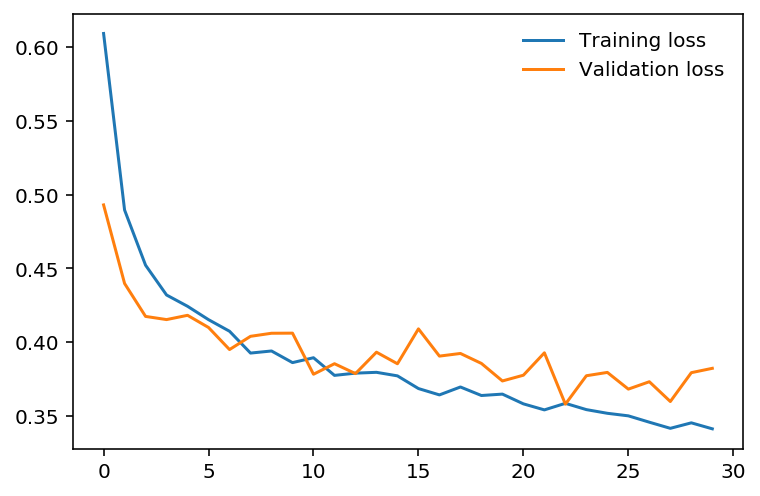

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

*recall*

**Inference**
- this is done after the training the network
- a term borrowed from statistics which actually means making predictions 
- **recall:** 
  - we use `model.eval()` to turn off Dropout
  - we use `torch.no_grad()` to turn off autograd

In [16]:
# folks the helper package always goes in the way as with the previous notebooks
# so don't forget this one if you're running in colab

!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

# if this doesn't still get through by running, reset your runtime and
# it will work

# also don't forget to change your Hardware Accelerator above to GPU for faster processing

--2020-01-10 16:33:48--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-01-10 16:33:49 (106 MB/s) - ‘helper.py’ saved [2813/2813]



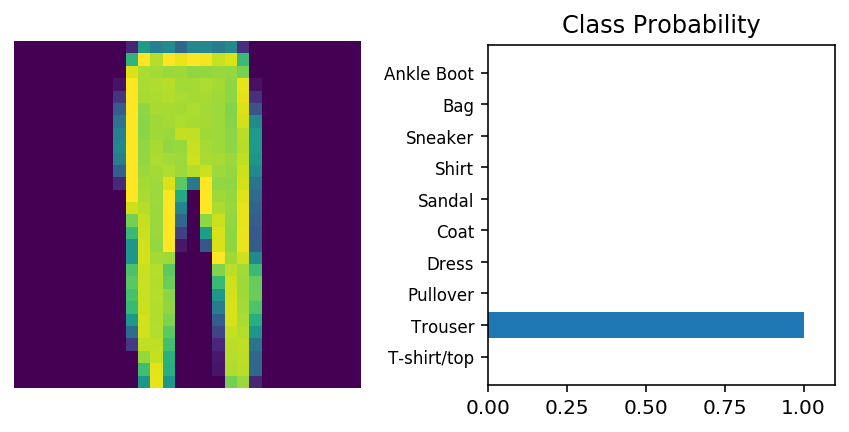

In [17]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

# Next Up!

Here, we saw the whole basic skeleton of our workflow with additional improvements. 

In the next part, as we've stated above, we'll need to save the trained models with the lowest validation loss. So we'll learn saving trained models. This can be done after training or after inference. Though, we may wanna load the model we saved for inference.